In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sqlalchemy import create_engine

## Evaluate model on gold standard hold-out set

### Using V1 model

In [2]:
# Load in test data
gold_df = pd.read_csv('../data/phase3/strong_label_cleaned.csv')
gold_df['strong_label'] = gold_df['strong_label'].str.lower()

label2id = {"negative": 0, "neutral": 1, "positive": 2}
gold_df['label'] = gold_df['strong_label'].map(label2id)

train_strong, temp_strong = train_test_split(gold_df,
                                            test_size=0.2,
                                            stratify=gold_df['label'],
                                            random_state=42)

val_strong, test_strong = train_test_split(temp_strong,
                                            test_size=0.5,
                                            stratify=temp_strong['label'],
                                            random_state=42)

# Load Tokenizer + trained model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('../models/v1')
model.eval()  # Set model to evaluation mode

# 3) Tokenize all test examples
encodings = tokenizer(
    test_strong["clean_body"].tolist(),
    truncation=True,
    padding="longest",
    return_tensors="pt"
)

# 4) Do a batched forward pass
with torch.no_grad():
    outputs = model(**encodings)
    logits  = outputs.logits
    preds   = torch.argmax(logits, dim=-1).cpu().numpy()

# 5) Compute and print classification metrics
y_true = test_strong["label"].values
print(classification_report(y_true, preds,
      target_names=["negative","neutral","positive"]))

# 6) Plot confusion matrix
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["neg","neu","pos"],
            yticklabels=["neg","neu","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Model V1")
plt.show()

### V2 Model

Added LR scheduling, warmup, early stopping, and class weights. Increased number of epochs, and adjusted learning rates.

              precision    recall  f1-score   support

    negative       0.80      0.66      0.72       212
     neutral       0.34      0.46      0.39        69
    positive       0.17      0.25      0.20        24

    accuracy                           0.58       305
   macro avg       0.44      0.46      0.44       305
weighted avg       0.65      0.58      0.61       305



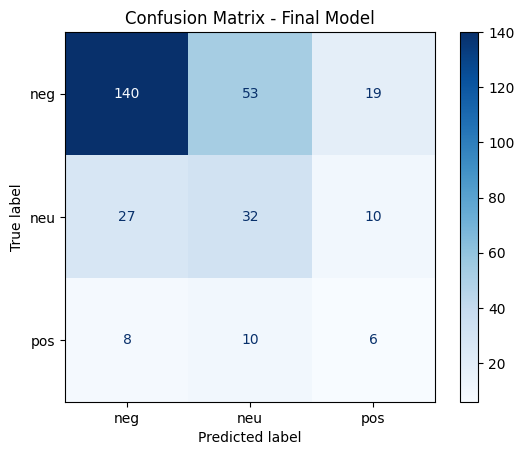

In [3]:
# Load V2 model
tokenizer = AutoTokenizer.from_pretrained('../models/final_model')
model_v2 = AutoModelForSequenceClassification.from_pretrained('../models/final_model')
model_v2.eval()  # Set model to evaluation mode

#Tokenize all test examples
encodings = tokenizer(
    test_strong["clean_body"].tolist(),
    truncation=True,
    padding="longest",
    return_tensors="pt"
)

# Do a batched forward pass
with torch.no_grad():
    outputs = model_v2(**encodings)
    logits  = outputs.logits
    preds   = torch.argmax(logits, dim=-1).cpu().numpy()

# Compute and print classification metrics
y_true = test_strong["label"].values
print(classification_report(y_true, preds,
      target_names=["negative","neutral","positive"]))

# Plot confusion matrix using ConfusionMatrixDisplay
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=["neg","neu","pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model")
plt.show()

### Generate sentiment signals on dataset

In [4]:
# Load predictions
df = pd.read_csv('../data/predictions.csv')
df.head()

,Unnamed: 0,id,subreddit,clean_body,date,pred_label,pred_score
0,0,esdguxz,geopolitics,why none?,2019-06-30 00:00:00.000000,1,0.547377
1,1,esdhtud,geopolitics,> who is the realist? it depends on what you m...,2019-06-30 00:00:00.000000,2,0.439600
2,2,esdj0ib,geopolitics,try outline.com,2019-06-30 00:00:00.000000,1,0.475402
3,3,esdj5ht,geopolitics,russia can only be a centralized state due to ...,2019-06-30 00:00:00.000000,1,0.468609
4,4,esdj6vs,geopolitics,migration is not a viable way to offset demogr...,2019-06-30 00:00:00.000000,1,0.398083


In [5]:
df["date"] = pd.to_datetime(df["date"]).dt.date
daily = df.groupby("date").agg(
  comment_count = ("id","count"),
  avg_score     = ("pred_score","mean"),
  pct_positive  = ("pred_label", lambda x:(x==2).mean()),
  pct_negative  = ("pred_label", lambda x:(x==0).mean()),
  pct_neutral   = ("pred_label", lambda x:(x==1).mean()),
).reset_index()


Text(0.5, 0, 'Date')

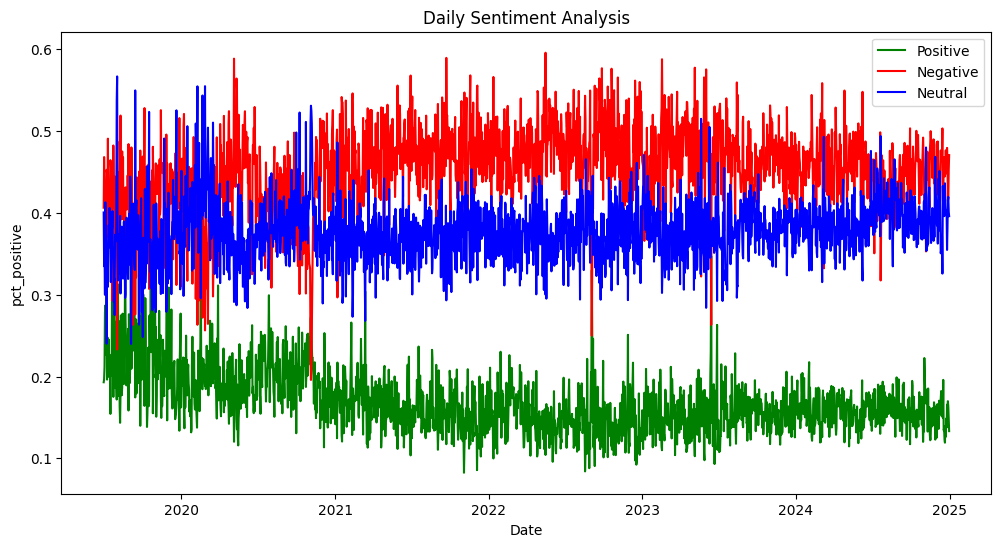

In [7]:
# Plot daily sentiment
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily, x='date', y='pct_positive', label='Positive', color='green')
sns.lineplot(data=daily, x='date', y='pct_negative', label='Negative', color='red')
sns.lineplot(data=daily, x='date', y='pct_neutral', label='Neutral', color='blue')
plt.title('Daily Sentiment Analysis')
plt.xlabel('Date')

### Load Gold Futures Data

In [8]:
# Load gold futures data
engine = create_engine('sqlite:///../reddit_posts.db')
gold = pd.read_sql_table('gold', engine)
gold.head()

,date,Close,High,Low,Open,Volume
0,2019-06-27,1408.400024,1410.800049,1399.800049,1407.000000,437
1,2019-06-28,1409.699951,1422.000000,1408.300049,1408.300049,356
2,2019-07-01,1385.599976,1395.800049,1382.800049,1386.599976,214
3,2019-07-02,1404.599976,1418.400024,1390.800049,1391.099976,38
4,2019-07-03,1417.699951,1434.000000,1413.099976,1431.000000,46


## Statistical Analysis

Trying to establish correlation between sentiment scores and gold futures.

In [9]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm

In [12]:
# Confirm date is datetime in gold and daily
gold['date'] = pd.to_datetime(gold['date'])
daily['date'] = pd.to_datetime(daily['date'])

In [47]:
# Merge gold and daily data
df = pd.merge(gold, daily, on='date', how='inner')

# Set date as index
df = df.set_index('date').sort_index()

# Compute pct returns for gold prices
df['pct_return'] = df['Close'].pct_change()

# Compute logged returns for gold prices
df['log_return'] = np.log(df['Close']).diff().dropna()

# Smooth sentiment with 7-day rolling mean
for col in ['pct_positive', 'pct_negative', 'pct_neutral']:
    df[f"{col}_7d"] = df[col].rolling(window=7).mean()
    
# Drop rows with NaN values
df = df.dropna()   
print(f"Dataframe shape after preprocessing: {df.shape}")

Dataframe shape after preprocessing: (1380, 15)


### ADF Stationarity

In [48]:
# Helper to run ADF test
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF test for {name}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  p-value:        {result[1]:.4f}\n")

# Run ADF test on gold prices and sentiment
for col in ['pct_positive_7d', 'pct_negative_7d', 'pct_neutral_7d', 'pct_return', 'log_return']:
    adf_test(df[col], col)

ADF test for pct_positive_7d:
  Test Statistic: -2.3663
  p-value:        0.1515

ADF test for pct_negative_7d:
  Test Statistic: -3.5391
  p-value:        0.0070

ADF test for pct_neutral_7d:
  Test Statistic: -4.2680
  p-value:        0.0005

ADF test for pct_return:
  Test Statistic: -15.9073
  p-value:        0.0000

ADF test for log_return:
  Test Statistic: -15.9094
  p-value:        0.0000



*Looks like positive sentiment is not stationary. We'll apply differencing and repeat the ADF test.*

In [51]:
# # Apply differencing to make series stationary
# df['pct_positive_diff'] = df['pct_positive_7d'].diff()

# # Remove NaN values after differencing
# df = df.dropna()

# Re-run ADF test on differenced series
adf_test(df['pct_positive_diff'], 'pct_positive_diff')

ADF test for pct_positive_diff:
  Test Statistic: -10.5474
  p-value:        0.0000



### Basic Correlation

In [52]:
# Pearson & Spearman between sentiment & returns
def correlation_tests(df, col1, col2):
    pearson_corr, pearson_pval = pearsonr(df[col1], df[col2])
    spearman_corr, spearman_pval = spearmanr(df[col1], df[col2])
    print(f"Correlation between {col1} and {col2}:")
    print(f"  Pearson: {pearson_corr:.4f}, p-value: {pearson_pval:.4f}")
    print(f"  Spearman: {spearman_corr:.4f}, p-value: {spearman_pval:.4f}\n")

for col in ['pct_positive_diff', 'pct_negative_7d', 'pct_neutral_7d']:
    correlation_tests(df, col, 'pct_return')
    correlation_tests(df, col, 'log_return')

Correlation between pct_positive_diff and pct_return:
  Pearson: 0.0335, p-value: 0.2133
  Spearman: 0.0440, p-value: 0.1021

Correlation between pct_positive_diff and log_return:
  Pearson: 0.0336, p-value: 0.2127
  Spearman: 0.0440, p-value: 0.1021

Correlation between pct_negative_7d and pct_return:
  Pearson: -0.0164, p-value: 0.5434
  Spearman: -0.0307, p-value: 0.2543

Correlation between pct_negative_7d and log_return:
  Pearson: -0.0144, p-value: 0.5938
  Spearman: -0.0307, p-value: 0.2543

Correlation between pct_neutral_7d and pct_return:
  Pearson: 0.0253, p-value: 0.3473
  Spearman: 0.0498, p-value: 0.0643

Correlation between pct_neutral_7d and log_return:
  Pearson: 0.0235, p-value: 0.3837
  Spearman: 0.0498, p-value: 0.0643



*All of these correlations are tiny, with insignificant p-values. In plain English: on a day-to-day basis, changes in positive-sentiment explain essentially none of the variation in gold returns.*

### Cross-correlation Function

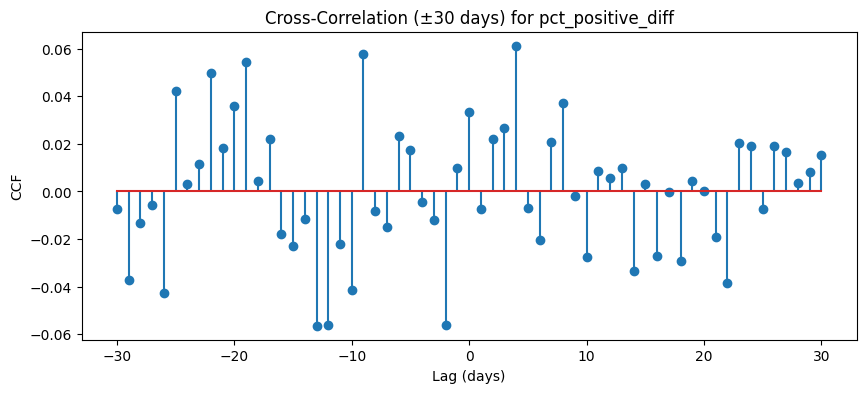

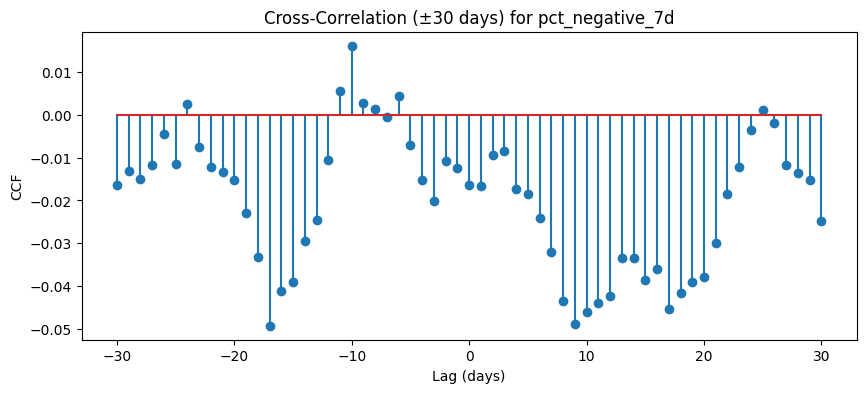

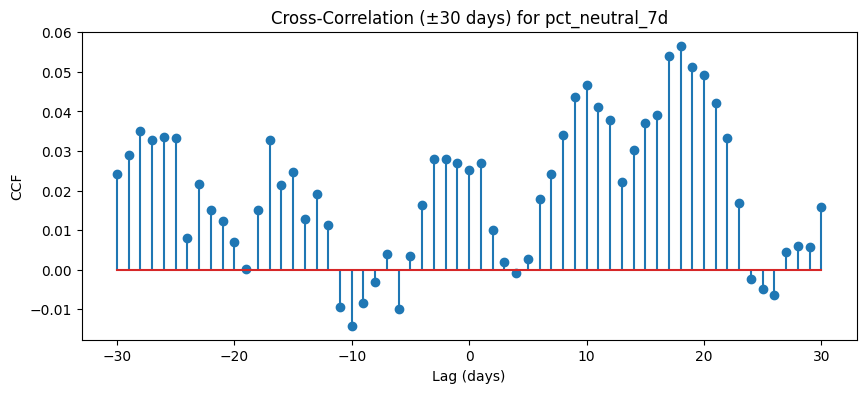

In [53]:
def cross_correlation(df, col1, col2):
    lags = np.arange(-30, 31)
    xcorr = np.correlate(
        df[col1] - df[col1].mean(),
        df[col2] - df[col2].mean(),
        mode='full'
    )
    xcorr = xcorr / (len(df) * df[col1].std() * df[col2].std())
    mid = len(xcorr) // 2
    xcorr  = xcorr[mid - 30: mid + 31]  # Keep only lags -30 to +30
    return lags, xcorr

def plot_ccf(lags, xcorr, col):
    plt.figure(figsize=(10,4))
    plt.stem(lags, xcorr)
    plt.title(f'Cross-Correlation (±30 days) for {col}')
    plt.xlabel('Lag (days)')
    plt.ylabel('CCF')
    plt.show()

# Cross-correlation between sentiment and returns
for col in ['pct_positive_diff', 'pct_negative_7d', 'pct_neutral_7d']:
    lags, xcorr = cross_correlation(df, col, 'pct_return')
    plot_ccf(lags, xcorr, col)

### Granger Causality

In [54]:
def granger_causality_test(df, col1, col2, max_lag=7):
    print(f"Granger causality test between {col1} and {col2}:")
    test_result = grangercausalitytests(df[[col1, col2]], max_lag)
    print()
    return test_result

# Granger causality tests
for col in ['pct_positive_diff']:
    granger_causality_test(df, col, 'pct_return', max_lag=7)
    granger_causality_test(df, col, 'log_return', max_lag=7)

Granger causality test between pct_positive_diff and pct_return:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2982  , p=0.5851  , df_denom=1375, df_num=1
ssr based chi2 test:   chi2=0.2988  , p=0.5846  , df=1
likelihood ratio test: chi2=0.2988  , p=0.5846  , df=1
parameter F test:         F=0.2982  , p=0.5851  , df_denom=1375, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5208  , p=0.5942  , df_denom=1372, df_num=2
ssr based chi2 test:   chi2=1.0454  , p=0.5929  , df=2
likelihood ratio test: chi2=1.0450  , p=0.5930  , df=2
parameter F test:         F=0.5208  , p=0.5942  , df_denom=1372, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4953  , p=0.6856  , df_denom=1369, df_num=3
ssr based chi2 test:   chi2=1.4934  , p=0.6838  , df=3
likelihood ratio test: chi2=1.4926  , p=0.6840  , df=3
parameter F test:         F=0.4953  , p=0.6856  , df_denom=1369, df_num=3

Granger Causality
numb

*Lags 1-6 have p-value over 0.05, and Lag 7 has p-value = 0.0447, which is basically insignificant, especially if we correct for multiple lag tests. In practice, the p-value at Lag 7 may just represent noise instead of an actual signal.*

### VAR and Impulse Response

/Users/AnshulSrivastava/Desktop/reddit-sentiment-trend/reddit-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


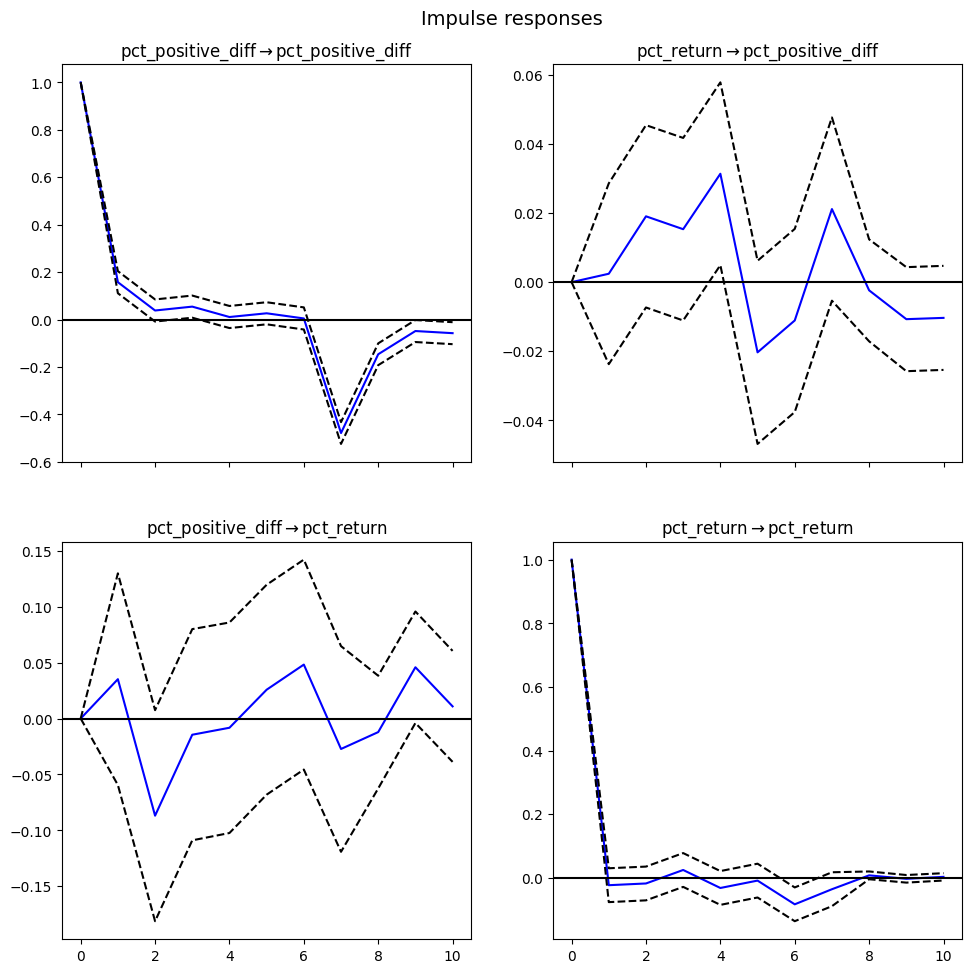

/Users/AnshulSrivastava/Desktop/reddit-sentiment-trend/reddit-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


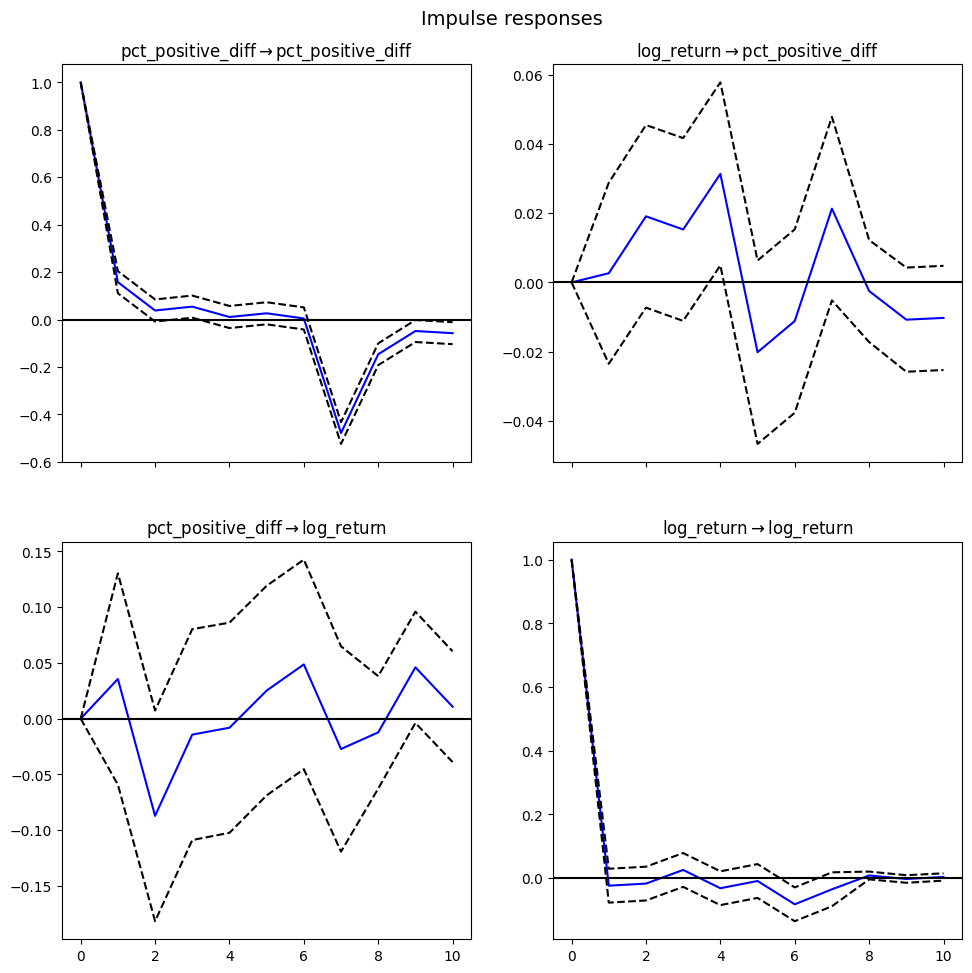

In [63]:
def impulse_response(df, col1, col2):
    model = VAR(df[[col1, col2]])
    results = model.fit(maxlags=7, ic='aic')

    irf = results.irf(10)  # Impulse response for 10 periods
    irf.plot(orth=False)
    plt.show()

# Impulse response analysis
for col in ['pct_positive_diff']:
    impulse_response(df, col, 'pct_return')
    impulse_response(df, col, 'log_return')

*Shock in returns → sentiment_diff: very small positive bump (≈0.02–0.05) after a few days.*
*Shock in sentiment_diff → returns: oscillates around zero (peaks ≈±0.05).*

*However, these magnitudes are trivial.*

### Bottom Line

- No meaningful contemporaneous correlation.
- No robust lead-lag effect. Any “significance” at lag 7 is almost certainly a statistical fluke.
- Impulse responses confirm that, at best, price moves nudge sentiment a hair—but sentiment moves don’t drive prices.

### Next Steps

We'll try experimenting with new features such as:
- Net sentiment (%pos - %neg), and weighing it by the number of comments on that day.
- Sentiment volatility: standard deviation of sentiment scores on a daily basis.
- Topic filtering: Try and focus on "gold" related chatter.

In [70]:
# Create net sentiment score
df['net_sentiment'] = df['pct_positive'] - df['pct_negative']

# Weighted net sentiment score
df['weighted_net_sentiment'] = df['net_sentiment'] * df['comment_count']

# Adjusted net sentiment score
df['net_adj'] = df['net_sentiment'] / (1 - df['pct_neutral']).replace(0, np.nan)
df['net_adj'] = df['net_adj'].fillna(0)

# Sentiment volatility
df['sentiment_volatility'] = df['net_sentiment'].rolling(window=7).std()

# Remove NaN values after all calculations
df = df.dropna()

In [72]:
# Check stationarity of new features
for col in ['net_sentiment', 'weighted_net_sentiment', 'net_adj', 'sentiment_volatility']:
    adf_test(df[col], col)

ADF test for net_sentiment:
  Test Statistic: -2.9215
  p-value:        0.0429

ADF test for weighted_net_sentiment:
  Test Statistic: -4.3392
  p-value:        0.0004

ADF test for net_adj:
  Test Statistic: -2.7829
  p-value:        0.0608

ADF test for sentiment_volatility:
  Test Statistic: -4.7031
  p-value:        0.0001



*We'll go ahead with weighted net sentiment and sentiment volatility as our features of choice.*

In [73]:
# Correlation tests for new features
for col in ['weighted_net_sentiment', 'sentiment_volatility']:
    correlation_tests(df, col, 'pct_return')
    correlation_tests(df, col, 'log_return')

Correlation between weighted_net_sentiment and pct_return:
  Pearson: 0.0176, p-value: 0.5157
  Spearman: -0.0069, p-value: 0.7998

Correlation between weighted_net_sentiment and log_return:
  Pearson: 0.0177, p-value: 0.5131
  Spearman: -0.0069, p-value: 0.7998

Correlation between sentiment_volatility and pct_return:
  Pearson: -0.0038, p-value: 0.8890
  Spearman: -0.0095, p-value: 0.7243

Correlation between sentiment_volatility and log_return:
  Pearson: -0.0037, p-value: 0.8910
  Spearman: -0.0095, p-value: 0.7243



*Again, we see barely any plausible correlation.*

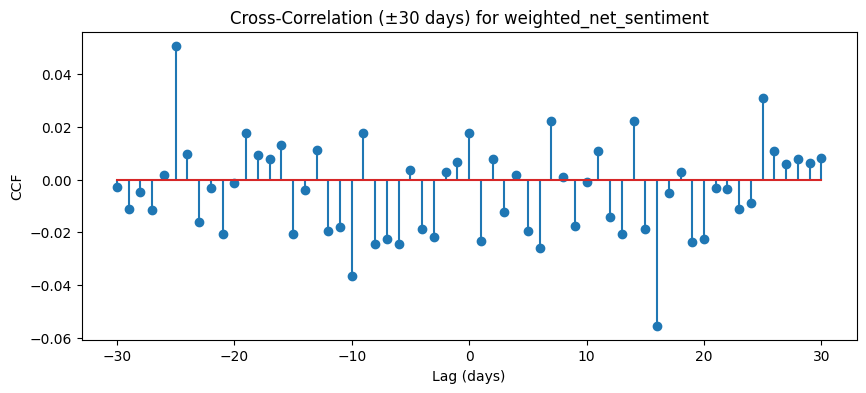

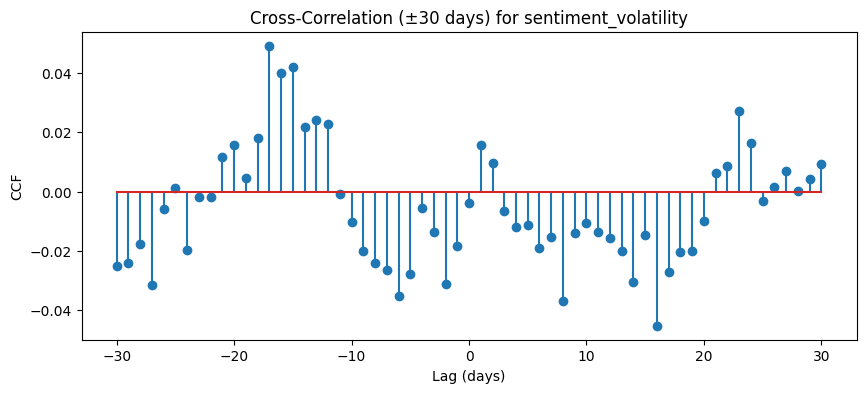

In [74]:
# Plot cross-correlation for new features
for col in ['weighted_net_sentiment', 'sentiment_volatility']:
    lags, xcorr = cross_correlation(df, col, 'pct_return')
    plot_ccf(lags, xcorr, col)

### Filtering for gold related chatter

In [75]:
# Load predictions
comments = pd.read_csv('../data/predictions.csv')

In [81]:
gold_comments = comments[comments['clean_body'].str.contains(r'\bgold\b', case=False, na=False)]
gold_comments['date'] = pd.to_datetime(gold_comments['date'])

# Check number of comments
len(gold_comments)

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_97060/971627177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_comments['date'] = pd.to_datetime(gold_comments['date'])


2043

*Not a large enough sample to conduct analysis*